In [1]:
# ! wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
# ! wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# ! gzip -d kddcup.data.gz

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.appName("Project")\
    .config("spark.driver.memory", "15g")\
    .config("spark.executor.memory", "15g")\
    .config("spark.memory.offHeap.enabled",True)\
    .config("spark.memory.offHeap.size","15g")\
    .getOrCreate()

spark.sparkContext.setLogLevel('WARN')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/29 13:44:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
with open("kddcup.names", "r") as f:
    names = f.readlines()
    dtypes = [name.split(":")[1].strip()[:-1] for name in names[1:]]
    dtypes = ['float' if dtype == 'continuous' else 'string' for dtype in dtypes]
    names = [name.split(":")[0] for name in names[1:]]
print(names, dtypes)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'] ['float', 'string', 'string', 'string', 'float', 'float', 'string', 'float', 'float', 'float', 'float', 'string', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'string', 'string', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'f

In [4]:
schema = StructType()
for name, dtype in zip(names, dtypes):
    schema.add(name, dtype)
schema.add("label", "string")

dtype_dict = dict(zip(names, dtypes))
dtype_dict["label"] = "string"
df = spark.read.csv("kddcup.data", header=False, schema=schema)
df = df.dropDuplicates()
df = df.dropna()
df.show(5)

23/11/29 13:44:49 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [5]:
# count distinct values for each string column
df.select([countDistinct(c).alias(c) for c in df.columns if dtype_dict[c]=='string']).show()

+-------------+-------+----+----+---------+-------------+--------------+-----+
|protocol_type|service|flag|land|logged_in|is_host_login|is_guest_login|label|
+-------------+-------+----+----+---------+-------------+--------------+-----+
|            3|     70|  11|   2|        2|            2|             2|   23|
+-------------+-------+----+----+---------+-------------+--------------+-----+



In [6]:
df = df.withColumn("label", when(col("label") == "normal.", 0).otherwise(1))
df = df.withColumnRenamed("label", "anomaly")

In [7]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

string_cols = [c for c in df.columns if c != "anomaly" and dtype_dict[c]=='string']
string_cols.remove("service")
string_cols.remove("flag")

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in string_cols]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

indexer = StringIndexer(inputCol="service", outputCol="service_index")
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol="flag", outputCol="flag_index")
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCols=["protocol_type_index", "land_index", "logged_in_index", "is_host_login_index", "is_guest_login_index", "service_index", "flag_index"], outputCols=["protocol_type_encoded", "land_encoded", "logged_in_encoded", "is_host_login_encoded", "is_guest_login_encoded", "service_encoded", "flag_encoded"])
df = encoder.fit(df).transform(df)

df = df.drop("protocol_type", "land", "logged_in", "is_host_login", "is_guest_login", "service", "flag", "protocol_type_index", "land_index", "logged_in_index", "is_host_login_index", "is_guest_login_index", "service_index", "flag_index")

In [8]:
# vectorize features
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=list(set(df.columns)-set(['anomaly'])), outputCol="features")
df = assembler.transform(df)
df = df.select("features", "anomaly")

In [9]:
# scale features
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)
df = df.select("scaled_features", "anomaly")

In [10]:
from pyspark.ml.feature import PCA
pca = PCA(k=90, inputCol="scaled_features", outputCol="pca_features")
model = pca.fit(df)

23/11/29 13:47:10 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/11/29 13:47:10 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [11]:
model.explainedVariance.sum()

0.9661579155925581

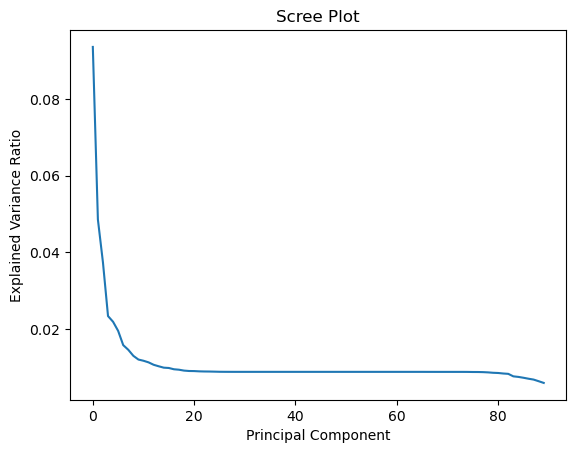

In [12]:
# plot explained variance ratio
plt.plot(model.explainedVariance.toArray()/model.explainedVariance.sum())
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title('Scree Plot')
plt.show()

# Since more than 95% of the variance is explained by the first 90 components, we can reduce the dimensionality of the data to 90 dimensions.

In [13]:
df = model.transform(df)
df = df.select("pca_features", "anomaly")
df.show(5)

+--------------------+-------+
|        pca_features|anomaly|
+--------------------+-------+
|[-3.3048224013264...|      0|
|[-3.4908481633426...|      0|
|[-3.6143258785923...|      0|
|[-3.7769945788024...|      0|
|[-3.8323102400812...|      0|
+--------------------+-------+
only showing top 5 rows



In [14]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)
print(train.count())
print(test.count())

752458


322534


## According to the literature review, AdaBoost had the best performance in the classification of the data. But, PySpark does not have an implementation of AdaBoost. So, we will use GBTClassifier instead.

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

gbt = GBTClassifier(labelCol="anomaly", featuresCol="pca_features", maxIter=10)
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [2, 5, 10])\
    .addGrid(gbt.maxBins, [10, 20, 40])\
    .addGrid(gbt.maxIter, [10, 20, 40])\
    .build()
evaluator = BinaryClassificationEvaluator(labelCol="anomaly", rawPredictionCol="prediction", metricName="areaUnderROC")
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)
print(cvModel.avgMetrics)
print(cvModel.bestModel)

# save the best model
cvModel.bestModel.save("best_model")

23/11/29 13:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB
23/11/29 13:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1003.9 KiB
23/11/29 13:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
23/11/29 13:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
23/11/29 13:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1006.1 KiB
23/11/29 13:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1008.3 KiB
23/11/29 13:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1011.3 KiB
23/11/29 13:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1015.5 KiB
23/11/29 13:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1022.9 KiB
23/11/29 13:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1034.8 KiB
23/11/29 13:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1052.8 KiB
23/11/29 13:51:20 WAR

23/11/29 13:52:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/11/29 13:52:34 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/29 13:52:34 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Area under ROC curve:  0.9993552338414612


23/11/29 13:52:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


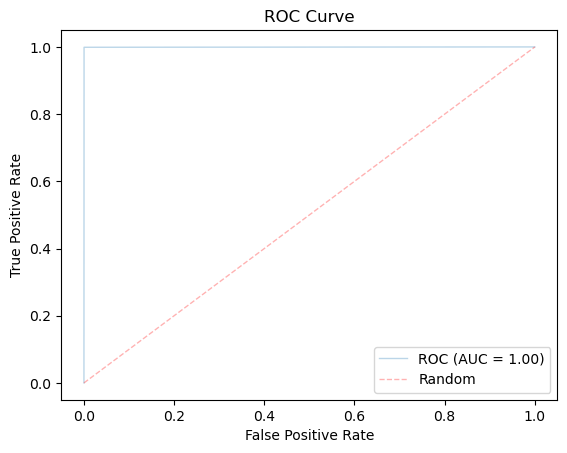

In [15]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(labelCol="anomaly", featuresCol="pca_features", maxIter=40, maxDepth=10, maxBins=40)
gbtModel = gbt.fit(train)

predictions = gbtModel.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol="anomaly", rawPredictionCol="prediction", metricName="areaUnderROC")
print("Area under ROC curve: ", evaluator.evaluate(predictions))

! pip install scikit-learn
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_true = np.array(predictions.select("anomaly").collect())
y_pred = np.array(predictions.select("prediction").collect())
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=0.3, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print('## Confusion Matrix ##')
print(cm)

## Confusion Matrix ##
[[244232     59]
 [    82  78161]]
